# Aula 2 - BigQuery e Data Studio 


In [1]:
import pandas as pd
import seaborn as sns
from google.colab import auth

### Forneça suas credenciais para o ambiente de execução

In [ ]:
auth.authenticate_user()
print('Authenticated')

Authenticated


### Execute a query para quantificar pessoas que não tomaram a 2a dose da vacina contra a COVID-19.



In [ ]:
# Salva o output numa variavel do tipo dataframe 
# enap-331414 é o project id do meu projeto no GPC

%%bigquery --project enap-331414 df_vacina
select uf, vacina, sum(naotomou2aDose) as qt_naotomou2aDose from (
SELECT v.id_paciente, v.sigla_uf AS uf, v.vacina,  
        (CASE WHEN min(v.data_aplicacao) = max(v.data_aplicacao) THEN 
	CASE WHEN v.vacina='86' THEN
	       case when (DATE_DIFF(current_date, max(v.data_aplicacao), day) > 30) then 1 else 0 end 
	ELSE 
	       case when (DATE_DIFF(current_date, max(v.data_aplicacao), day) > 90) then 1 else 0 end
              END
        ELSE 0 
        END
        ) AS naotomou2aDose,
FROM `basedosdados.br_ms_vacinacao_covid19.microdados_vacinacao` v
WHERE v.sigla_uf='AC' or v.sigla_uf='AP'
GROUP BY v.id_paciente, uf, vacina
LIMIT 1000
) group by uf, vacina;


In [ ]:
df_vacina

,uf,vacina,qt_naotomou2aDose
0,AP,86,55
1,AP,85,119
2,AP,87,67
3,AP,89,18


# Repita a operação usando o pandas-gbq



In [7]:
## Defina o id do seu projeto no bigquery!!!!!
project_id = 'enap-331414' # Defina o id do seu projeto no bigquery!!!!!
## Defina o id do seu projeto no bigquery!!!!!

df_vacina = pd.io.gbq.read_gbq('''
  select uf, vacina, sum(naotomou2aDose) as qt_naotomou2aDose from (
SELECT v.id_paciente, v.sigla_uf AS uf, v.vacina,  
        (CASE WHEN min(v.data_aplicacao) = max(v.data_aplicacao) THEN 
	CASE WHEN v.vacina='86' THEN
	       case when (DATE_DIFF(current_date, max(v.data_aplicacao), day) > 30) then 1 else 0 end 
	ELSE 
	       case when (DATE_DIFF(current_date, max(v.data_aplicacao), day) > 90) then 1 else 0 end
              END
        ELSE 0 
        END
        ) AS naotomou2aDose,
FROM `basedosdados.br_ms_vacinacao_covid19.microdados_vacinacao` v
WHERE (v.sigla_uf='AC' or v.sigla_uf='AP') and (v.vacina='89' or v.vacina='88' or v.vacina='86')
GROUP BY v.id_paciente, uf, vacina
LIMIT 1000000
) group by uf, vacina
''', project_id=project_id)

df_vacina.head()

,uf,vacina,qt_naotomou2aDose
0,AP,86,27384
1,AP,89,15241
2,AP,88,9692
3,AC,86,19786
4,AC,89,16511


In [ ]:
df_vacina.to_gbq("enapdatasets.vacinacao",
              project_id=project_id,
              chunksize=40000,
              if_exists='replace',
              )

## Operações de tabela pivotada (pivot table)

#### Exemplo 1

In [2]:
# URL de acesso web de uma planilha excel compartilhada no google drive
url='https://docs.google.com/spreadsheets/d/16B0uAFH1hubqvXytaxEkh9J8fXAJugYi/edit?usp=sharing'
# URL de download de uma planilha excel compartilhada no google drive
url2='https://drive.google.com/uc?id=' + url.split('/')[-2] 
df_revenue = pd.read_excel(url2)
df_revenue


,Country,Quarter,Year,Revenue
0,United States,Q3,2017,198.50
1,Hong Kong,Q3,2017,70.21
2,Canada,Q3,2017,52.74
3,Mexico,Q3,2017,42.36
4,United States,Q4,2017,36.37
5,Venezuela,Q3,2017,33.49
6,Ireland,Q4,2017,27.25
7,Australia,Q3,2017,27.10
8,Singapore,Q3,2017,25.19
9,(not set),Q4,2017,23.80


In [3]:
df_pivoted = df_revenue.pivot(index='Country', columns=['Year','Quarter'], values='Revenue')
df_pivoted

Year             2017       
Quarter            Q3     Q4
Country                     
(not set)         NaN  23.80
Australia       27.10    NaN
Canada          52.74    NaN
Hong Kong       70.21    NaN
Ireland           NaN  27.25
Mexico          42.36    NaN
Singapore       25.19    NaN
United States  198.50  36.37
Venezuela       33.49    NaN

### Treine o encadeamento (chaining) de métodos
##### Encadear funções elimina o fardo cognitivo de nomear variáveis a cada passo intermediário. É mais difícil de depurar, tenha certeza do que está fazendo e aprimore esta habilidade.
##### Mais detalhes [aqui](https://tomaugspurger.github.io/method-chaining.html) e [aqui](https://towardsdatascience.com/the-unreasonable-effectiveness-of-method-chaining-in-pandas-15c2109e3c69)

#### Pivoteamento da tabela de vacinação gerada anteriormente:

In [8]:
df_pivoted = df_vacina.pivot(index='uf', columns=['vacina'], values='qt_naotomou2aDose').reset_index()
df_pivoted

vacina,uf,86,88,89
0,AC,19786,10995,16511
1,AP,27384,9692,15241


#### Faça o despivoteamento deste dataframe usando o metodo melt
##### Dica: digite o nome do método, e digite CTRL+<ESPAÇO> com o cursor sobre o nome do método para ver a assinatura do método.

In [9]:
df_pivoted.columns

Index(['uf', '86', '88', '89'], dtype='object', name='vacina')

In [10]:
df_pivoted.melt(id_vars=['uf'])

,uf,vacina,value
0,AC,86,19786
1,AP,86,27384
2,AC,88,10995
3,AP,88,9692
4,AC,89,16511
5,AP,89,15241


In [13]:
df_pivoted.melt(id_vars=['uf'], value_vars=['89', '86'])

,uf,vacina,value
0,AC,89,16511
1,AP,89,15241
2,AC,86,19786
3,AP,86,27384


In [17]:
df_melt = df_pivoted.melt(id_vars=['uf'], value_vars=['89', '86'], value_name='qt_naotomou2aDose')
df_melt

,uf,vacina,qt_naotomou2aDose
0,AC,89,16511
1,AP,89,15241
2,AC,86,19786
3,AP,86,27384


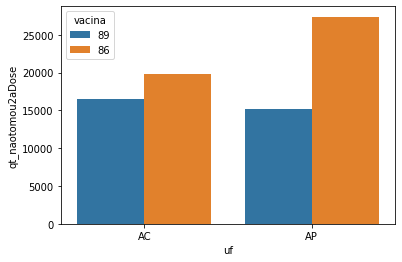

In [18]:
import seaborn as sns
sns.barplot(x='uf', y='qt_naotomou2aDose', hue='vacina', data=df_melt)

#### EDA (Exploratory Data Analysis) com Seaborn
#### Plote um gráfico de barras com uma coluna para cada vacina e uma barra de cor diferente para cada UF.

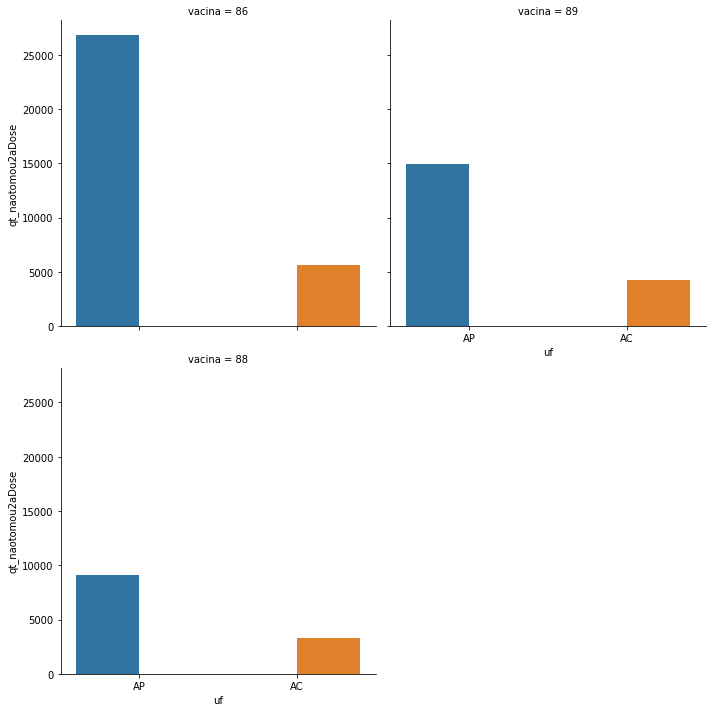

In [ ]:
sns.catplot(kind='bar', data=df_vacina, x='uf', col='vacina', hue='uf', y='qt_naotomou2aDose', col_wrap=2)

#### Perceba que a tabela despivotada é útil para fazer um gráfico com a análise de várias séries de dados (vacinas e UFs).
#### Faça EDA com Seaborn para agilizar seu ciclo de feedback e a busca por insights de negócio.

#### Exemplo 2

In [19]:
# Considere o seguinte DataFrame
table = {
    'Aluno': ['AlunoA', 'AlunoA', 'AlunoA', 'AlunoA', 'AlunoB', 'AlunoB', 'AlunoB', 'AlunoB'],
    'Disciplina': ['Portugues', 'Matematica', 'Geografia', 'História', 'Portugues', 'Matematica', 'Geografia', 'História'],
    'Objetiva': [8.5, 7.5, 9, 10, 8.5, 7.5, 9, 10]}
df_provas = pd.DataFrame(table)
df_provas

,Aluno,Disciplina,Objetiva
0,AlunoA,Portugues,8.5
1,AlunoA,Matematica,7.5
2,AlunoA,Geografia,9.0
3,AlunoA,História,10.0
4,AlunoB,Portugues,8.5
5,AlunoB,Matematica,7.5
6,AlunoB,Geografia,9.0
7,AlunoB,História,10.0


In [20]:
# Pivote o dataframe df_provas colocando a coluna Aluno como índice, 
# os valores da coluna Disciplina como colunas, e os valores da coluna Objetiva
# como conteúdo do novo dataframe
df_pivoted = df_provas.pivot(index='Aluno', columns='Disciplina', values=['Objetiva'])
df_pivoted

Objetiva                              
Disciplina Geografia História Matematica Portugues
Aluno                                             
AlunoA           9.0     10.0        7.5       8.5
AlunoB           9.0     10.0        7.5       8.5

#### E quando houver valores repetidos ?
Pivotar com o mesmo método pivot() gera exceção. Neste caso, use o método pivot_table
mean é a métrica padrão de cálculo sobre a de agregação

In [21]:
# Considere o seguinte DataFrame
table2 = {
    'Aluno': ['AlunoA', 'AlunoA', 'AlunoA', 'AlunoA', 'AlunoA', 'AlunoB', 'AlunoB', 'AlunoB', 'AlunoB'],
    'Disciplina': ['Portugues', 'Matematica', 'Geografia', 'Geografia', 'História', 'Portugues', 'Matematica', 'Geografia', 'História'],
    'Objetiva': [8.5, 7.5, 9, 10, 9, 8.5, 7.5, 9, 10]}
df_provas2 = pd.DataFrame(table2)
df_provas2

,Aluno,Disciplina,Objetiva
0,AlunoA,Portugues,8.5
1,AlunoA,Matematica,7.5
2,AlunoA,Geografia,9.0
3,AlunoA,Geografia,10.0
4,AlunoA,História,9.0
5,AlunoB,Portugues,8.5
6,AlunoB,Matematica,7.5
7,AlunoB,Geografia,9.0
8,AlunoB,História,10.0


In [24]:
# Pivotar com o mesmo comando gera uma exceção
# df_pivoted2 = df_provas2.pivot(index='Aluno', columns='Disciplina', values='Objetiva')
# Use a funcao pivot_table. O valor padrão do argumento aggfunc é 'mean'
df_pivoted2 = df_provas2.pivot_table(index='Aluno', columns='Disciplina', values='Objetiva',
                                    aggfunc='max')
df_pivoted2

Disciplina,Geografia,História,Matematica,Portugues
Aluno,,,,
AlunoA,10.0,9.0,7.5,8.5
AlunoB,9.0,10.0,7.5,8.5
